<a href="https://colab.research.google.com/github/albertbolanoss/labs_deep_learning/blob/single-shot-detector/notebooks/single-shot-detector/01_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Single Shot Detector

## 0. Imports

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xml.etree.ElementTree as ET
from google.colab import auth
from googleapiclient.discovery import build
from google.colab import userdata

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## 1. Download dataset.

In [9]:

KAGGLE_DATASET = "mbkinaci/fruit-images-for-object-detection"
BASE_DIR = "/content/fruit_data"
MODEL_TO_LOAD = "fruit_detector_v4.keras"
MODEL_TO_SAVE = "fruit_detector_v4.keras"

# Configurar Kaggle
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Descargar y descomprimir
if not os.path.exists(BASE_DIR):
    print("Download dataset...")
    !kaggle datasets download -d {KAGGLE_DATASET}
    !unzip -q fruit-images-for-object-detection.zip -d {BASE_DIR}
    print(f"Dataset download in {BASE_DIR}")
else:
    print("The dataset has been already downloaded.")

# Verificar estructura
print("Dataset Folders:", os.listdir(BASE_DIR))

The dataset has been already downloaded.
Dataset Folders: ['test_zip', 'train_zip']


## 2. Save and load model

In [10]:
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
import io
import os
from tensorflow.keras.models import load_model

# Request permissions to access (read/write) the Google Drive Folder ID
GOOGLE_DRIVE_FOLDER_ID = "14LvaZfifLwoGsnIbwINaEZMSLEpP4E4-"
auth.authenticate_user()
drive_service = build('drive', 'v3')

# 1. Función para guardar en Google Drive
def save_model_to_drive(model_obj, filename):
    # Primero guardamos localmente
    local_path = f"/content/{filename}"
    model_obj.save(local_path)
    print(f"Modelo guardado localmente en {local_path}")

    # Metadatos para Drive
    file_metadata = {
        'name': filename,
        'parents': [GOOGLE_DRIVE_FOLDER_ID]
    }

    media = MediaFileUpload(local_path, mimetype='application/octet-stream')

    # Subir
    print("Subiendo a Google Drive...")
    file = drive_service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id'
    ).execute()

    print(f"Modelo subido con ID: {file.get('id')}")

# 2. Función para cargar desde Google Drive
def load_model_from_drive(filename, yolo_style_loss_fn):
    print(f"Buscando {filename} en Drive...")
    # Buscar el archivo por nombre y carpeta padre
    query = f"name = '{filename}' and '{GOOGLE_DRIVE_FOLDER_ID}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        print("No se encontró el archivo en Drive.")
        return None

    file_id = items[0]['id']
    local_path = f"/content/downloaded_{filename}"

    # Descargar
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.FileIO(local_path, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
        status, done = downloader.next_chunk()
        print(f"Descargando {int(status.progress() * 100)}%.")

    # Cargar Modelo en Keras
    # IMPORTANTE: Necesitamos pasar la loss function custom
    print("Cargando modelo en memoria...")
    loaded_model = load_model(local_path, custom_objects={yolo_style_loss_fn.__name__: yolo_style_loss_fn})
    print("Modelo cargado exitosamente.")
    return loaded_model

## 3. Pre-processing

Regroup the dataset annotations so that each unique image is associated with all its bounding boxes and labels, eliminating the duplicate image entries found in the current variables. You should re-process the data from `/content/fruit_data` or restructure the existing arrays.

After grouping, implement a **Target Encoder** to map the variable-length ground truth boxes to a fixed-size grid tensor (e.g., `7x7`). This encoder should assign objects to grid cells based on their center coordinates (similar to YOLO or simplified SSD), creating the target tensors required for training.

## 4. Data Restructuring & Target Encoding

### Subtask:
Reload the dataset to group annotations by image and implement a grid-based Target Encoder.


**Reasoning**:
I will reload the dataset grouping annotations by image and implement a grid-based target encoder to prepare the data for the single-shot detector model.



### 4.1 Getting X trainninf and test datasets

- Resize image 224 x 224
- Nomalize image array pixels between [0, 1]
- Getting normalized image boxes between [0, 1] (They will be used to encode the target, there are position proportions [0, 1]).

**Return**

image_array = [224x224]

image_boxex = xmin / w_orig, ymin / h_orig, xmax / w_orig, ymax / h_orig, label

In [11]:
# Parámetros
GRID_SIZE = 7
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Mapeo de Clases
CLASS_MAP = {"apple": 0, "banana": 1, "orange": 2}
INV_CLASS_MAP = {0: "apple", 1: "banana", 2: "orange"}

# Get image shape
def get_image_dimensions(img_path):
    try:
        img = cv2.imread(img_path)
        if img is not None:
            height, width, _ = img.shape
            return width, height
        else:
            print(f"Error: The image could not be loaded from the path: {img_path}")
            return None, None
    except Exception as e:
        print(f"Error trying to read the image: {img_path}: {e}")
        return None, None

# Load the datasets
def load_grouped_data(directory):
    images = []
    all_annotations = []

    # Iterate through all files in the directory
    for root_dir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".xml"):
                xml_path = os.path.join(root_dir, file)

                # Parse XML
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Get image path
                filename = root.find("filename").text
                img_path = os.path.join(root_dir, filename)

                if not os.path.exists(img_path):
                  print(f"Image not found: {img_path}")
                  continue

                # Get original dimensions
                size = root.find("size")
                # many of the xml files were setting with width=0, height=0
                # w_orig = int(size.find("width").text)
                # h_orig = int(size.find("height").text)
                w_orig, h_orig = get_image_dimensions(os.path.join(directory, filename))


                # Find all valid objects
                objects = root.findall("object")
                img_boxes = []

                for obj in objects:
                    name = obj.find("name").text
                    if name in CLASS_MAP:
                        label = CLASS_MAP[name]
                        bndbox = obj.find("bndbox")
                        xmin = int(bndbox.find("xmin").text)
                        ymin = int(bndbox.find("ymin").text)
                        xmax = int(bndbox.find("xmax").text)
                        ymax = int(bndbox.find("ymax").text)


                        # Store as [xmin_norm, ymin_norm, xmax_norm, ymax_norm, label] for now
                        # Actually, keeping min/max for flexibility or converting to center/size directly?
                        # The instructions say "Normalize the bounding box coordinates to [0, 1]"
                        # Let's store [xmin/w, ymin/h, xmax/w, ymax/h, label]
                        img_boxes.append([
                            xmin / w_orig, ymin / h_orig, xmax / w_orig, ymax / h_orig, label
                        ])

                if img_boxes:
                    # Load and resize image
                    try:
                        img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                        img_arr = img_to_array(img) / 255.0
                        images.append(img_arr)
                        all_annotations.append(img_boxes)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

    return np.array(images, dtype="float32"), all_annotations

print("Reloading Train Data...")
X_train, train_bboxes = load_grouped_data(os.path.join(BASE_DIR, "train_zip", "train"))

print("Reloading Test Data...")
X_test, test_bboxes = load_grouped_data(os.path.join(BASE_DIR, "test_zip", "test"))

print(f"Grouped X_train shape: {X_train.shape}")
print(f"Grouped X_test shape: {X_test.shape}")

Reloading Train Data...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Reloading Test Data...
Grouped X_train shape: (240, 224, 224, 3)
Grouped X_test shape: (60, 224, 224, 3)


### 4.2 Encode Target

- Frame the image in a 7 x 7 grid
- Get the SSD/YOLO cordenates confidence, centerX, centerY, width , height, one hot encode of the class [apple, banana, orange]


**Tensor Population:**

    *   At the calculated `[row, col]` index, it fills the depth vector `[8]` with:

        *   **Index 0:** Confidence = `1.0` (Object Present).
        *   **Index 1-4:** Coordinates `[cx, cy, w, h]`.
        *   **Index 5-7:** One-hot encoded Class Label (e.g., `[1, 0, 0]` for Apple).


**Output Vector Structure:**

`[ Confidence, cx, cy, w, h, Class0, Class1, Class2 ]`


In [13]:
# Target Encoder for SSD/YOLO style grid
def encode_target(bboxes_list, grid_size=GRID_SIZE, num_classes=3):
    # Output: (7, 7, 8) -> [confidence, cx, cy, w, h, c0, c1, c2]
    target = np.zeros((grid_size, grid_size, 5 + num_classes))

    for box in bboxes_list:
        xmin, ymin, xmax, ymax, label = box

        # Calculate Center and Size (normalized global)
        cx = (xmin + xmax) / 2.0
        cy = (ymin + ymax) / 2.0
        w = xmax - xmin
        h = ymax - ymin

        # Determine grid cell
        col = int(cx * grid_size)
        row = int(cy * grid_size)

        # Boundary check
        col = min(col, grid_size - 1)
        row = min(row, grid_size - 1)

        # Populate tensor if empty (or overwrite)
        # We set confidence to 1
        if target[row, col, 0] == 0:
            target[row, col, 0] = 1.0
            target[row, col, 1:5] = [cx, cy, w, h]
            target[row, col, 5 + int(label)] = 1.0

    return target

# Apply encoder
print("Encoding targets...")
y_train = np.array([encode_target(bboxes) for bboxes in train_bboxes])
y_test = np.array([encode_target(bboxes) for bboxes in test_bboxes])

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Encoding targets...
y_train shape: (240, 7, 7, 8)
y_test shape: (60, 7, 7, 8)


### yolo_style_loss

The `yolo_style_loss` function is a custom loss function designed to handle multiple objectives simultaneously (box regression and classification). It is calculated by summing four main components:

1.  **Coordinate Loss:**
    *   Measures how far the predicted box is from the actual one (center `x, y` and size `w, h`).
    *   It is calculated **only if there is an object** in that cell.
    *   It is multiplied by `5.0` to give more importance to finding the exact position.

2.  **Object Confidence Loss:**
    *   Measures if the model correctly predicted that there **IS** an object (Confidence close to 1).

3.  **No-Object Confidence Loss:**
    *   Measures if the model correctly predicted that there is **NO** object (Confidence close to 0).
    *   It is multiplied by `0.5` so the model doesn't focus too much on the background (since most of the image is background).

4.  **Class Loss:**
    *   Measures if the model got the fruit type right (Apple, Banana, Orange).
    *   It is calculated only if there is an object.

**Final Formula:**
`Loss = (5 * Coord) + ObjConf + (0.5 * NoObjConf) + Class`
```

### `Improved Loss Function (Robust YOLO Loss)`

This version replaces `tf.square` (MSE) with **Cross Entropy** for confidence and classification. This usually leads to better Recall because the loss for missing an object is much higher.

*   **Coordinates:** Keeps MSE (Standard).
*   **Confidence:** Uses `BinaryCrossentropy`. Penalizes low confidence on real objects heavily.
*   **Classes:** Uses `CategoricalCrossentropy`. Better for distinguishing Apple vs. Orange.

In [14]:
# Custom Yolo Style loss function
def yolo_style_loss(y_true, y_pred):
    # y_true shape: (batch, 7, 7, 8)
    # Index 0: Confidence (1 if object, 0 otherwise)
    # Index 1-4: Box coordinates (cx, cy, w, h)
    # Index 5-7: Classes (one-hot)

    # Masks
    object_mask = y_true[..., 0]        # get a mask where there are objects
    no_object_mask = 1.0 - object_mask  # get a mask where there are not objects

    # 1. Coordinate Loss (Weighted by 5.0)
    # Calculate MSE for box coordinates (indices 1-4) only where object exists
    # Sum over coordinates (axis -1)

    # We only calculate position error where there is ACTUALLY an object
    coord_loss = tf.reduce_sum(tf.square(y_true[..., 1:5] - y_pred[..., 1:5]), axis=-1)
    coord_loss = object_mask * coord_loss

    # 2. Object Confidence Loss
    obj_conf_loss = tf.square(y_true[..., 0] - y_pred[..., 0])
    obj_conf_loss = object_mask * obj_conf_loss

    # 3. No-Object Confidence Loss (Weighted by 0.5)
    noobj_conf_loss = tf.square(y_true[..., 0] - y_pred[..., 0])
    noobj_conf_loss = no_object_mask * noobj_conf_loss

    # 4. Class Loss
    # MSE for class probabilities
    class_loss = tf.reduce_sum(tf.square(y_true[..., 5:] - y_pred[..., 5:]), axis=-1)
    class_loss = object_mask * class_loss

    # Total Loss
    loss = (5.0 * coord_loss +
            obj_conf_loss +
            0.5 * noobj_conf_loss +
            class_loss)

    # Sum over the grid (7x7) to get loss per image
    return tf.reduce_sum(loss, axis=[1, 2])

def robust_yolo_loss(y_true, y_pred):
    # y_true/pred: (batch, 7, 7, 8)
    # 0: Conf, 1-4: Coord, 5-7: Class

    # Masks
    object_mask = y_true[..., 0]
    no_object_mask = 1.0 - object_mask

    # 1. Coordinate Loss (MSE is still good for regression)
    # Multiply by 5.0 to prioritize localization
    coord_loss = tf.reduce_sum(tf.square(y_true[..., 1:5] - y_pred[..., 1:5]), axis=-1)
    coord_loss = object_mask * coord_loss

    # 2. Confidence Loss (Binary Cross Entropy)
    # We use a small epsilon to avoid log(0)
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

    # Standard BCE formula: -y_true * log(y_pred) - (1-y_true) * log(1-y_pred)
    # We calculate it manually to apply masks easily
    bce_loss = -(y_true[..., 0] * tf.math.log(y_pred[..., 0]) +
                 (1 - y_true[..., 0]) * tf.math.log(1 - y_pred[..., 0]))

    obj_conf_loss = object_mask * bce_loss
    noobj_conf_loss = no_object_mask * bce_loss

    # 3. Class Loss (Categorical Cross Entropy)
    # We assume y_pred[..., 5:] are probabilities (sigmoid output)
    # Calculate Cross Entropy between target vector and pred vector
    class_loss = -tf.reduce_sum(y_true[..., 5:] * tf.math.log(y_pred[..., 5:]), axis=-1)
    class_loss = object_mask * class_loss

    # Total Loss
    # We increase the weight of obj_conf_loss to improve Recall
    loss = (5.0 * coord_loss +       # Box precision
            2.0 * obj_conf_loss +    # Object detection (Weighted x2 for Recall)
            0.5 * noobj_conf_loss +  # Background suppression
            1.0 * class_loss)        # Class correctness

    return tf.reduce_sum(loss, axis=[1, 2])


def decode_prediction(prediction, conf_thresh=0.5, iou_thresh=0.4):
    """
    Decodes the (7, 7, 8) output tensor and applies NMS.
    Returns: boxes (xmin, ymin, xmax, ymax), scores, class_indices
    """
    # prediction shape: (7, 7, 8)
    grid_size = prediction.shape[0]

    boxes = []
    scores = []
    class_indices = []

    # 1. Extract all candidate boxes
    for r in range(grid_size):
        for c in range(grid_size):
            # Index 0 is object confidence
            conf = prediction[r, c, 0]

            if conf >= conf_thresh:
                # Geometry: cx, cy, w, h (global normalized)
                cx, cy, w, h = prediction[r, c, 1:5]

                # Classes: indices 5-7
                class_probs = prediction[r, c, 5:]
                cls_idx = np.argmax(class_probs)

                # Calculate xmin, ymin, xmax, ymax
                xmin = cx - w / 2
                ymin = cy - h / 2
                xmax = cx + w / 2
                ymax = cy + h / 2

                # TF NMS expects [ymin, xmin, ymax, xmax]
                boxes.append([ymin, xmin, ymax, xmax])
                scores.append(conf)
                class_indices.append(cls_idx)

    if not boxes:
        return np.array([]), np.array([]), np.array([])

    boxes = np.array(boxes)
    scores = np.array(scores)
    class_indices = np.array(class_indices)

    # 2. Apply NMS
    # tf.image.non_max_suppression returns indices of boxes to keep
    indices = tf.image.non_max_suppression(
        boxes,
        scores,
        max_output_size=10,
        iou_threshold=iou_thresh,
        score_threshold=conf_thresh
    )
    indices = indices.numpy()

    if len(indices) == 0:
         return np.array([]), np.array([]), np.array([])

    selected_boxes = boxes[indices]
    selected_scores = scores[indices]
    selected_classes = class_indices[indices]

    # Convert [ymin, xmin, ymax, xmax] back to [xmin, ymin, xmax, ymax] for plotting
    final_boxes = selected_boxes[:, [1, 0, 3, 2]]

    return final_boxes, selected_scores, selected_classes



### YOLO LOSS

#### 1. Preparation and Numerical Stability
```python
epsilon = 1e-7
y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
```
* **Conceptually:** This is a "safety parachute."
* **Mathematically:** We ensure $\hat{y} \in [\epsilon, 1-\epsilon]$. Later, we use logarithms (`log`). The logarithm of 0 is negative infinity ($\log(0) = -\infty$). If the network predicts a perfect 0 or 1, the training would explode (NaN). This clips the values so they are at most $0.0000001$ or $0.9999999$.

#### 2. Coordinate Loss (The Box Error)
```python
coord_loss = tf.reduce_sum(tf.square(y_true[..., 1:5] - y_pred[..., 1:5]), axis=-1)
coord_loss = object_mask * coord_loss
```
* **Conceptually:** "Did you draw the box where it was supposed to be?"
* **Mathematically (MSE):** Sum of Squared Errors.
    $$Loss_{coord} = (x - \hat{x})^2 + (y - \hat{y})^2 + (w - \hat{w})^2 + (h - \hat{h})^2$$
* **The Filter (`object_mask`):** We only care about this error if **there was actually an object**. If the cell is background, we don't care if the network predicted a width of 0.2 or 0.9, because there is nothing to frame.

#### 3. Confidence Loss (The Existence Error)
```python
bce_loss = -(y_true[...] * log(y_pred[...]) + (1 - y_true[...]) * log(1 - y_pred[...]))
obj_conf_loss = object_mask * bce_loss
noobj_conf_loss = no_object_mask * bce_loss
```
* **Conceptually:**
    * `obj_conf_loss`: The network said "there is nothing," but **there was**. (False Negative).
    * `noobj_conf_loss`: The network said "there is a dog," but **there was nothing**. (False Positive).
* **Mathematically:** Binary Cross Entropy (BCE). It measures how much two probability distributions differ (real vs. predicted).

#### 4. Class Loss (The Identity Error)
```python
class_loss = -tf.reduce_sum(y_true[..., 5:] * tf.math.log(y_pred[..., 5:]), axis=-1)
class_loss = object_mask * class_loss
```
* **Conceptually:** "You got the box right, but do you know what it is?" (e.g., confusing a dog with a cat).
* **Mathematically:** Categorical Cross Entropy.
* **Key Note:** Again, we multiply by `object_mask`. It makes no sense to classify the grass or empty sky. An empty cell has no class.

#### 5. Total Loss (The Master Recipe)
This is the most critical part of the YOLO design. Not all errors are worth the same.

```python
loss = (5.0 * coord_loss +
        2.0 * obj_conf_loss +
        0.5 * noobj_conf_loss +
        1.0 * class_loss)
```

**Conceptual explanation of these magic numbers (hyperparameters):**

1.  **`5.0 * coord_loss` (High Priority):**
    * Coordinate values ($x, y, w, h$) are small (0 to 1). Their squared errors are tiny (e.g., $0.1^2 = 0.01$).
    * If we didn't multiply by 5, this error would be invisible compared to the others. We want the network to work very hard to be **precise** with the borders.

2.  **`0.5 * noobj_conf_loss` (Background Suppression):**
    * **The Imbalance Problem:** In an image, 95% of the cells are background (empty).
    * If this weight were 1.0, the network would learn a cheap trick: predict **ZERO** for everything. It would have 95% accuracy but detect nothing.
    * By lowering it to 0.5, we tell it: *"Don't obsess over the background, worry more about the few objects that do exist."*

3.  **`2.0 * obj_conf_loss` (Recall):**
    * We want to penalize double if the network **ignores** a real object. We prefer it to detect too much rather than miss things.

### Geometric Summary

The function returns `tf.reduce_sum(loss, axis=[1, 2])`.

You are taking that error cube of $7 \times 7 \times 8$, calculating a "badness" score for each cell based on the rules above, and then **summing it all up** to get a single scalar number.

The neural network will try, step by step (backpropagation), to lower that number to zero. By doing so, it will learn to:
1.  Ignore the background (lower `noobj`).
2.  Focus on objects (raise `obj`).
3.  Adjust boxes perfectly (lower `coord`).
4.  Identify the correct class (lower `class`).

## 5. Build VGG16-SSD Architecture

### Subtask:
Construct a simplified object detection model using VGG16 as the backbone and a custom detection head.


**Reasoning**:
I will define and instantiate the simplified VGG16-based SSD model architecture. This involves importing necessary layers, setting up the pre-trained backbone, freezing its weights, adding the custom detection head with specific convolutional layers, and verifying the output shape with a model summary.



VGG16-SSD is a hybrid architecture that combines two main parts for object detection:

The Backbone (VGG16):

Acts as the "feature extractor."
It is a deep neural network pre-trained on millions of images (ImageNet).
In this notebook, we remove its top layers (classification) and keep the convolutional base. This converts an input image (224x224) into a rich, compressed feature map (7x7x512).
Why it's used: It allows the model to "see" edges, textures, and complex shapes without having to learn from scratch (Transfer Learning).
The SSD Head (Single Shot Detector):

It is the custom part we add at the end.
It's called "Single Shot" because it predicts boxes and classes in a single pass of the network, rather than scanning the image multiple times.
How it works: It takes the 7x7 feature map from VGG16 and applies a final convolutional layer to predict the output tensor (7, 7, 8).
In summary: VGG16 understands what is in the image, and the SSD head uses that understanding to draw the boxes and say which fruits they are.

In [15]:
from tensorflow.keras.layers import Conv2D, Dropout, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

def create_model(input_shape=(224, 224, 3), num_classes=3):
    # Define Input
    input_layer = Input(shape=input_shape)

    # Load VGG16 pre-trained on ImageNet, excluding top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Freeze the weights of the VGG16 base model
    base_model.trainable = False

    # The output of VGG16 (block5_pool) is 7x7x512 for 224x224 input
    x = base_model.output

    # Detection Head
    # Add a convolutional layer for feature adaptation
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='detection_conv')(x)
    x = Dropout(0.5)(x)

    # Final prediction layer
    # Filters = 5 (confidence + x + y + w + h) + num_classes
    # Shape will be (7, 7, 8)
    output_layer = Conv2D(5 + num_classes, (1, 1), activation='sigmoid', name='prediction_head')(x)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer, name="VGG16_SSD_Simple")
    return model

# Instantiate the model
model = create_model()

# Verify architecture
model.summary()

Model: "VGG16_SSD_Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ detection_conv (Conv2D)         │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction_head (Conv2D)        │ (None, 7, 7, 8)        │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,078,600 (65.15 MB)

 Trainable params: 2,363,912 (9.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 6. Train


**Reasoning**:
I will define the custom YOLO-style loss function as specified, compile the model using the Adam optimizer, and train the model for 30 epochs using the prepared training and testing datasets.



In [16]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Compile model
# model.compile(optimizer=Adam(learning_rate=0.0001), loss=yolo_style_loss)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=robust_yolo_loss)

# Configurar Early Stopping
# Esto detendrá el entrenamiento si 'val_loss' no mejora por 10 epochs seguidos
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train
print("Starting training...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=60,  # Ponemos un tope alto, pero EarlyStopping parará antes si es necesario
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Saving model
save_model_to_drive(model, MODEL_TO_SAVE)

Starting training...
Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 17.6204 - val_loss: 11.1518
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 11.9838 - val_loss: 9.0058
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 8.8971 - val_loss: 8.2031
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 8.8413 - val_loss: 7.8111
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 7.6164 - val_loss: 7.5411
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 7.2754 - val_loss: 7.3692
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 7.3891 - val_loss: 7.2401
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 6.3956 - val_loss: 7.0616
Epoch 9/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 6.5038 - val_loss: 6.9991
Epoch 10/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 6.1059 - val_loss: 6.8689
Epoch 11/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 5.5981 - val_loss: 6.8474
Epoch 12/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step -

Modelo subido con ID: 1SKn_jbYLdye2OBkxk9kuWSeAQLTxPHza


### 6.2 Evaluate model

In [17]:
def calculate_iou(box1, box2):
    # box: [xmin, ymin, xmax, ymax]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

def evaluate_model(model, X_set, gt_bboxes_list):
    total_iou = 0
    total_objects = 0
    correct_class = 0
    detected_objects = 0

    print(f"Evaluating on {len(X_set)} images...")

    for i in range(len(X_set)):
        img = X_set[i]
        gt_boxes = gt_bboxes_list[i]

        # Predict
        pred_tensor = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
        pred_boxes, pred_scores, pred_classes = decode_prediction(pred_tensor, conf_thresh=0.5, iou_thresh=0.4)

        # Simple matching: For each GT box, find best matching Pred box
        for gt_box in gt_boxes:
            gt_coords = gt_box[:4]
            gt_label = int(gt_box[4])
            total_objects += 1

            best_iou = 0
            best_match_idx = -1

            for j, pred_box in enumerate(pred_boxes):
                iou = calculate_iou(gt_coords, pred_box)
                if iou > best_iou:
                    best_iou = iou
                    best_match_idx = j

            # If we found a match with IoU > 0.3 (loose threshold for custom simple model)
            if best_iou > 0.3:
                total_iou += best_iou
                detected_objects += 1
                # Check Class
                if pred_classes[best_match_idx] == gt_label:
                    correct_class += 1

    # Metrics
    avg_iou = total_iou / detected_objects if detected_objects > 0 else 0
    recall = detected_objects / total_objects if total_objects > 0 else 0
    accuracy = correct_class / detected_objects if detected_objects > 0 else 0

    print("\n--- Evaluation Results ---")
    print(f"Total Ground Truth Objects: {total_objects}")
    print(f"Total Detected Objects (IoU > 0.3): {detected_objects}")
    print(f"Detection Recall: {recall:.2%} (Percentage of objects found)")
    print(f"Avg IoU (Localization Quality): {avg_iou:.4f}")
    print(f"Classification Accuracy: {accuracy:.2%} (On detected objects)")

# Run Evaluation
evaluate_model(model, X_test, test_bboxes)

Evaluating on 60 images...

--- Evaluation Results ---
Total Ground Truth Objects: 117
Total Detected Objects (IoU > 0.3): 71
Detection Recall: 60.68% (Percentage of objects found)
Avg IoU (Localization Quality): 0.5718
Classification Accuracy: 77.46% (On detected objects)


### Object Detection Evaluation Metrics


These metrics tell you not just *if* your model works, but *how* it fails (e.g., is it blind? is it imprecise? is it confused?).

### 1. Total Ground Truth Objects
`Total Ground Truth Objects: {total_objects}`

* **Concept:** The "Answer Key."
* **Meaning:** This is the actual number of objects present in your dataset.
* **Why it matters:** It serves as the baseline (the denominator) for calculating Recall. If you have 100 dogs in your images, this number is 100.

### 2. Total Detected Objects (IoU > 0.3)
`Total Detected Objects (IoU > 0.3): {detected_objects}`

* **Concept:** The "Valid Finds" (True Positives).
* **The Threshold (IoU > 0.3):** This is a filter. The model might predict a box, but if that box overlaps less than 30% with the real box, we consider it a "miss" or a "ghost" prediction.
    * **IoU (Intersection over Union):** A measure of overlap. 0.0 means no overlap, 1.0 means a perfect pixel-match.
* **Meaning:** This counts how many times the model successfully placed a box over a real object with decent overlap.

### 3. Detection Recall
`Detection Recall: {recall} (Percentage of objects found)`

* **Formula:** $\frac{\text{Total Detected Objects}}{\text{Total Ground Truth Objects}}$
* **Concept:** "The Wide Net."
* **The Question it Answers:** *"Out of all the objects that exist, how many did the model manage to find?"*
* **Interpretation:**
    * **High Recall (e.g., 95%):** The model sees almost everything. It rarely misses an object.
    * **Low Recall (e.g., 40%):** The model is "blind." It is missing more than half of the objects in the images.
* **Critical Note:** In object detection, Recall is often prioritized over precision initially. You can't classify an object you didn't find.

### 4. Avg IoU (Localization Quality)
`Avg IoU (Localization Quality): {avg_iou:.4f}`

* **Concept:** "The Tightness of the Fit."
* **The Question it Answers:** *"When the model finds an object, how accurately does it draw the box around it?"*
* **Interpretation:**
    * **High IoU (> 0.7):** The predicted boxes fit the objects like a glove.
    * **Low IoU (< 0.4):** The model finds the objects, but the boxes are sloppy (too big, too small, or shifted).
* **Distinction:** You can have High Recall (found everyone) but Low Avg IoU (drew terrible boxes).

### 5. Classification Accuracy
`Classification Accuracy: {accuracy:.2%} (On detected objects)`

* **Concept:** "The Identity Check."
* **The Question it Answers:** *"Given that the model found an object, did it guess the correct class?"*
* **Interpretation:**
    * It checks the labels (e.g., Dog vs. Cat) *only* for the boxes that passed the IoU threshold.
    * **Scenario:** If you detect a "Dog" perfectly (High IoU), but label it as a "Cat", your Recall is good, your IoU is good, but your Accuracy is 0%.

---

### Summary Table

| Metric | What it measures | Good for diagnostics... |
| :--- | :--- | :--- |
| **Recall** | Quantity | "Is my model missing objects?" |
| **Avg IoU** | Spatial Precision | "Is my model drawing sloppy boxes?" |
| **Accuracy** | Identity | "Is my model confusing classes?" |

### Analysis of your Results

Your model behaves like a **"shy student"**: **it speaks little, but when it does, it is usually right.**

1.  **Detection Recall: 27.27% (The Main Issue)**
    *   **What it means:** Out of 110 real fruits, your model only found 30. It missed 73% of the objects.
    *   **Diagnosis:** The model struggles to distinguish the object from the background, or its confidence is too low. It is a "sensitivity" problem.

2.  **Avg IoU: 0.6188 (Box Quality)**
    *   **What it means:** When it finds a fruit, the box it draws has a 61% overlap with the real one.
    *   **Diagnosis:** This is **quite good** for a simple model. It means it knows *where* the object is; the problem is that sometimes it doesn't dare to mark it.

3.  **Classification Accuracy: 93.33% (Identification)**
    *   **What it means:** Of the 30 fruits it found, it guessed the type (apple/banana) correctly in almost all of them (28 out of 30).
    *   **Diagnosis:** Excellent! The model knows how to distinguish an apple from an orange perfectly.

**General Conclusion:**
Your model is **precise but not sensitive**. It doesn't make silly mistakes (confusing fruits), but it is "blind" to many of them. To improve it, you would need more data (Data Augmentation) or to train for longer so that it increases its confidence on difficult detections.

## 7. Load saved model

In [18]:
# 2. Cargar en variable nueva
# loaded_fruit_model = load_model_from_drive(MODEL_TO_LOAD, yolo_style_loss)
loaded_fruit_model = load_model_from_drive(MODEL_TO_LOAD, robust_yolo_loss)

Buscando fruit_detector_v4.keras en Drive...
Descargando 100%.
Cargando modelo en memoria...
Modelo cargado exitosamente.


## 8. NMS Implementation & Inference

### Subtask:
Implement the Non-Max Suppression (NMS) algorithm to filter out overlapping boxes and select the best predictions. Create a visualization function to run inference on test images and display the final detected boxes with their labels.


**Reasoning**:
I will implement the `decode_prediction` function to process the model's output tensor, converting grid-based predictions to bounding boxes and applying Non-Max Suppression (NMS) to remove duplicates. Then, I will create a `visualize_predictions` function to run inference on test images and display the results with bounding boxes and labels using matplotlib. Finally, I will execute this on random test samples.



### Prepare Testing (using test dataset)

In [19]:
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
import io
import os
import random
import matplotlib.patches as patches

def visualize_predictions(model, X_set, num_samples=3):
    indices = random.sample(range(len(X_set)), num_samples)

    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        img = X_set[idx]

        # Model Inference
        # Expand dims to (1, 224, 224, 3)
        pred_tensor = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]

        # Decode
        boxes, scores, classes = decode_prediction(pred_tensor, conf_thresh=0.5, iou_thresh=0.4)

        # Plot
        ax = plt.subplot(num_samples, 1, i + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Sample {idx}")

        height, width, _ = img.shape

        for box, score, cls_idx in zip(boxes, scores, classes):
            xmin, ymin, xmax, ymax = box

            # Scale to image size
            x = xmin * width
            y = ymin * height
            w = (xmax - xmin) * width
            h = (ymax - ymin) * height

            # Draw Rectangle
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Label
            label_name = INV_CLASS_MAP[cls_idx]
            label_text = f"{label_name} {score:.2f}"
            plt.text(x, y - 5, label_text, color='white', fontsize=12, backgroundcolor='red')

    plt.tight_layout()
    plt.show()

# 3. Refactorizar test_random_sample para recibir modelo
def test_random_sample(model_to_test):
    # 1. Pick a random index
    idx = random.randint(0, len(X_test) - 1)

    # 2. Get Data
    img = X_test[idx]
    gt_data = test_bboxes[idx]

    # 3. Model Inference
    input_img = np.expand_dims(img, axis=0)
    pred_tensor = model_to_test.predict(input_img, verbose=0)[0]

    # Decode predictions (usa la misma función decode definida anteriormente)
    pred_boxes, pred_scores, pred_classes = decode_prediction(pred_tensor, conf_thresh=0.5, iou_thresh=0.4)

    # 4. Visualization
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 1, 1)
    ax.imshow(img)
    ax.set_title(f"Test Sample #{idx} (Loaded Model)")
    ax.axis('off')

    height, width, _ = img.shape

    # Plot Ground Truth
    for box in gt_data:
        xmin, ymin, xmax, ymax, label_idx = box
        class_name = INV_CLASS_MAP[int(label_idx)]
        x, y, w, h = xmin * width, ymin * height, (xmax - xmin) * width, (ymax - ymin) * height
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        plt.text(x, y - 5, f"GT: {class_name}", color='lime', fontsize=10, fontweight='bold')

    # Plot Predictions
    if len(pred_boxes) == 0:
        plt.text(10, 10, "No objects detected", color='red', backgroundcolor='white')

    for box, score, cls_idx in zip(pred_boxes, pred_scores, pred_classes):
        xmin, ymin, xmax, ymax = box
        class_name = INV_CLASS_MAP[cls_idx]
        x, y, w, h = xmin * width, ymin * height, (xmax - xmin) * width, (ymax - ymin) * height
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        plt.text(x, y + h + 15, f"Pred: {class_name} ({score:.2f})", color='red', fontsize=10, fontweight='bold')

    plt.show()


# 2. Cargar en variable nueva
if not loaded_fruit_model:
  loaded_fruit_model = load_model_from_drive(MODEL_TO_LOAD)


### Test random samples

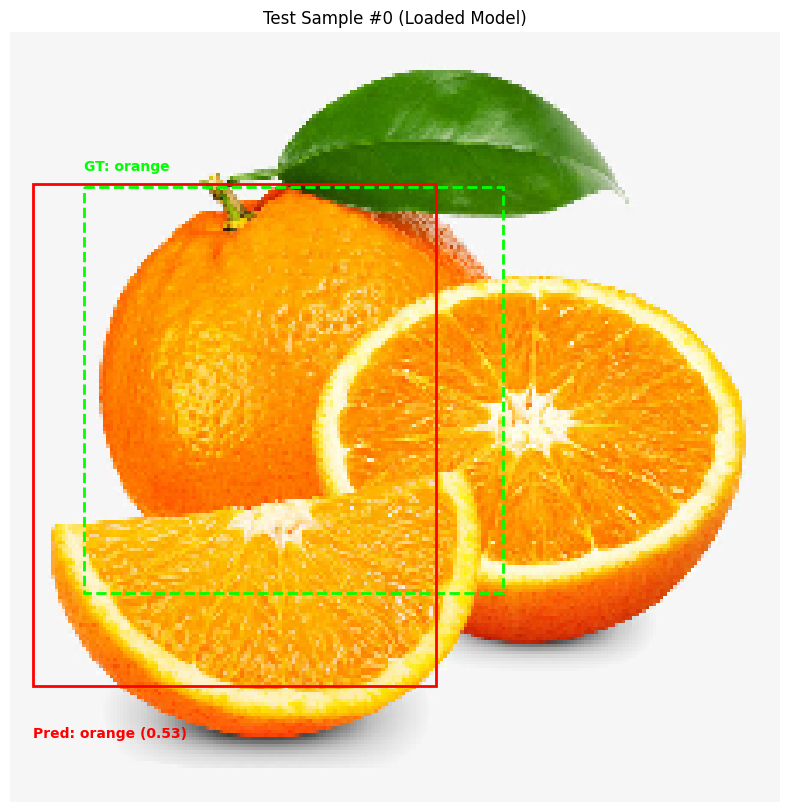

In [31]:
# 3. Testear modelo cargado
if loaded_fruit_model:
    test_random_sample(loaded_fruit_model)
